In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
from tqdm import tqdm
import os

In [2]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n_sample = len(x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_sample

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(train_x.shape[1], 128),      # Increase the number of neurons
            nn.ReLU(),
            nn.Dropout(0.5),                # Add dropout for regularization
            nn.Linear(128, 64),             # Add another layer
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(dim=1)  
        )
    def forward(self, x):
        return self.net(x)

In [4]:
df = pd.read_csv("adult_300.csv")
df = df.drop(columns=['capital-gain', 'capital-loss'])
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,54,Private,1st-4th,2,Married-civ-spouse,Other-service,Husband,White,Male,40,Mexico,<=50K
1,24,Private,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,United-States,<=50K
2,20,Private,Some-college,10,Never-married,Machine-op-inspct,Own-child,White,Female,40,United-States,<=50K
3,38,Self-emp-not-inc,Masters,14,Married-civ-spouse,Farming-fishing,Husband,White,Male,70,United-States,<=50K
4,37,Private,Bachelors,13,Never-married,Tech-support,Not-in-family,White,Female,40,United-States,<=50K


In [5]:
# Function to apply LabelEncoder on multiple columns
def label_encode_columns(df, columns):
    le = LabelEncoder()
    for column in columns:
        df[column] = le.fit_transform(df[column])
    return df

# Apply LabelEncoder on the specified columns
df_encoded = label_encode_columns(df, df.columns)
df_encoded.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,37,2,3,0,1,6,0,4,1,21,11,0
1,7,2,11,7,1,2,0,4,1,28,17,0
2,3,2,14,8,3,5,3,4,0,21,17,0
3,21,4,12,12,1,3,0,4,1,36,17,0
4,20,2,9,11,3,10,1,4,0,21,17,0


In [6]:
# transform pandas type into numpy type
adult_x = df[['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']].values
adult_y = df['income'].values
print(type(adult_x))
print(adult_x.shape)
print(type(adult_y))
print(adult_y.shape)

<class 'numpy.ndarray'>
(300, 11)
<class 'numpy.ndarray'>
(300,)


In [7]:
# normalize
minmax = MinMaxScaler()
adult_x = minmax.fit_transform(adult_x)

In [8]:
# split dataset into training and validation
train_x, valid_x, train_y, valid_y = train_test_split(adult_x, adult_y, test_size=0.2, random_state=1)
valid_x, test_x, valid_y, test_y = train_test_split(valid_x, valid_y, test_size=0.5, random_state=1)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(test_y.shape)

(240, 11)
(240,)
(30, 11)
(30,)
(30, 11)
(30,)


In [9]:
train_x = torch.tensor(train_x, dtype=torch.float32)
valid_x = torch.tensor(valid_x, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
valid_y = torch.tensor(valid_y, dtype=torch.long)
test_y = torch.tensor(test_y, dtype=torch.long)

In [10]:
train_set = dataset(train_x, train_y)
valid_set = dataset(valid_x, valid_y)
test_set = dataset(test_x, test_y)
batch_size = 8
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [11]:
device=torch.device('cuda')
step_size=1000
learning_rate = 0.001
epoch = 250

model = Model().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size,0.1)
train_acc_his,train_losses_his,valid_acc_his,valid_losses_his=[],[],[],[]
for i in range(1, epoch+1):
    print('Running Epoch:'+str(i))
    train_correct,train_loss,train_total,valid_correct,valid_loss,valid_total=0,0,0,0,0,0
    model.train()
    for samples,labels in tqdm(train_loader, desc=f'Epoch {i} - Training'):
        samples, labels = samples.to(device), labels.to(device)
        pred = model(samples)
        loss = criterion(pred, labels)
        output_id = torch.max(pred, dim=1)[1]
        train_correct += np.sum(torch.eq(labels, output_id).cpu().numpy())
        train_loss += loss.item()*samples.size(0)
        train_total += samples.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    for samples,labels in valid_loader:
        samples, labels = samples.to(device), labels.to(device)
        pred = model(samples)
        loss = criterion(pred, labels)
        output_id = torch.max(pred, dim=1)[1]
        valid_correct += np.sum(torch.eq(labels, output_id).cpu().numpy())
        valid_loss += loss.item()*samples.size(0)
        valid_total += samples.size(0)
    
    train_acc = train_correct/train_total*100
    train_loss = train_loss/train_total
    valid_acc = valid_correct/valid_total*100
    valid_loss = valid_loss/valid_total
    train_acc_his.append(train_acc)
    train_losses_his.append(train_loss)
    valid_acc_his.append(valid_acc)
    valid_losses_his.append(valid_loss)
    print(f'Training Loss= {train_loss}')
    print(f'Training Acc(%)= {train_acc}')
    print(f'Validation Acc(%)= {valid_acc}')

Model(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=2, bias=True)
    (6): Softmax(dim=1)
  )
)
Running Epoch:1


Epoch 1 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 126.82it/s]


Training Loss= 0.6943838715553283
Training Acc(%)= 50.416666666666664
Validation Acc(%)= 70.0
Running Epoch:2


Epoch 2 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 597.05it/s]


Training Loss= 0.6868366658687591
Training Acc(%)= 55.41666666666667
Validation Acc(%)= 70.0
Running Epoch:3


Epoch 3 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 763.87it/s]


Training Loss= 0.6729299743970235
Training Acc(%)= 64.16666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:4


Epoch 4 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 735.61it/s]


Training Loss= 0.6575259824593862
Training Acc(%)= 64.16666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:5


Epoch 5 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 722.59it/s]


Training Loss= 0.6355014562606811
Training Acc(%)= 70.41666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:6


Epoch 6 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 765.22it/s]


Training Loss= 0.6251168767611186
Training Acc(%)= 67.5
Validation Acc(%)= 73.33333333333333
Running Epoch:7


Epoch 7 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 774.36it/s]


Training Loss= 0.6367340862751008
Training Acc(%)= 62.5
Validation Acc(%)= 73.33333333333333
Running Epoch:8


Epoch 8 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 717.97it/s]


Training Loss= 0.5969863186279932
Training Acc(%)= 72.5
Validation Acc(%)= 80.0
Running Epoch:9


Epoch 9 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 832.20it/s]


Training Loss= 0.5961753765741984
Training Acc(%)= 69.16666666666667
Validation Acc(%)= 70.0
Running Epoch:10


Epoch 10 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 740.47it/s]


Training Loss= 0.5949245383342107
Training Acc(%)= 69.58333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:11


Epoch 11 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 796.41it/s]


Training Loss= 0.5776470383008321
Training Acc(%)= 72.91666666666666
Validation Acc(%)= 73.33333333333333
Running Epoch:12


Epoch 12 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 758.23it/s]


Training Loss= 0.5769407510757446
Training Acc(%)= 70.0
Validation Acc(%)= 73.33333333333333
Running Epoch:13


Epoch 13 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 790.64it/s]


Training Loss= 0.5637387742598852
Training Acc(%)= 75.41666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:14


Epoch 14 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 772.66it/s]


Training Loss= 0.5697253157695135
Training Acc(%)= 73.75
Validation Acc(%)= 73.33333333333333
Running Epoch:15


Epoch 15 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.59it/s]


Training Loss= 0.5512769430875778
Training Acc(%)= 77.91666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:16


Epoch 16 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 737.53it/s]


Training Loss= 0.5595006118218104
Training Acc(%)= 73.75
Validation Acc(%)= 73.33333333333333
Running Epoch:17


Epoch 17 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 793.15it/s]


Training Loss= 0.555971105893453
Training Acc(%)= 74.16666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:18


Epoch 18 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 857.09it/s]


Training Loss= 0.566702714562416
Training Acc(%)= 74.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:19


Epoch 19 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 794.79it/s]


Training Loss= 0.5544795781373978
Training Acc(%)= 76.25
Validation Acc(%)= 73.33333333333333
Running Epoch:20


Epoch 20 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 769.26it/s]


Training Loss= 0.5453509648640951
Training Acc(%)= 73.33333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:21


Epoch 21 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 712.75it/s]


Training Loss= 0.5504116793473561
Training Acc(%)= 74.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:22


Epoch 22 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 783.15it/s]


Training Loss= 0.5466431111097336
Training Acc(%)= 77.5
Validation Acc(%)= 73.33333333333333
Running Epoch:23


Epoch 23 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 736.17it/s]


Training Loss= 0.536395537853241
Training Acc(%)= 77.08333333333334
Validation Acc(%)= 73.33333333333333
Running Epoch:24


Epoch 24 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 679.25it/s]


Training Loss= 0.5243500282367071
Training Acc(%)= 78.75
Validation Acc(%)= 73.33333333333333
Running Epoch:25


Epoch 25 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 697.95it/s]


Training Loss= 0.5431182970603307
Training Acc(%)= 75.83333333333333
Validation Acc(%)= 80.0
Running Epoch:26


Epoch 26 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 706.67it/s]


Training Loss= 0.5229765931765239
Training Acc(%)= 78.33333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:27


Epoch 27 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 763.28it/s]


Training Loss= 0.5350711842377981
Training Acc(%)= 76.25
Validation Acc(%)= 76.66666666666667
Running Epoch:28


Epoch 28 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 758.59it/s]


Training Loss= 0.5258842557668686
Training Acc(%)= 77.5
Validation Acc(%)= 76.66666666666667
Running Epoch:29


Epoch 29 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 814.06it/s]


Training Loss= 0.5304177771011989
Training Acc(%)= 76.66666666666667
Validation Acc(%)= 80.0
Running Epoch:30


Epoch 30 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 828.98it/s]


Training Loss= 0.5340160051981608
Training Acc(%)= 78.75
Validation Acc(%)= 80.0
Running Epoch:31


Epoch 31 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 753.88it/s]


Training Loss= 0.5373714754978816
Training Acc(%)= 76.66666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:32


Epoch 32 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 762.99it/s]


Training Loss= 0.5020160506169001
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:33


Epoch 33 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 797.38it/s]


Training Loss= 0.5267918229103088
Training Acc(%)= 77.5
Validation Acc(%)= 73.33333333333333
Running Epoch:34


Epoch 34 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 774.43it/s]


Training Loss= 0.5070930133263271
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 80.0
Running Epoch:35


Epoch 35 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 761.62it/s]


Training Loss= 0.5099872837464015
Training Acc(%)= 78.75
Validation Acc(%)= 83.33333333333334
Running Epoch:36


Epoch 36 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 736.07it/s]


Training Loss= 0.5143526862064998
Training Acc(%)= 79.16666666666666
Validation Acc(%)= 76.66666666666667
Running Epoch:37


Epoch 37 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 714.90it/s]


Training Loss= 0.5154633621374766
Training Acc(%)= 78.33333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:38


Epoch 38 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 669.65it/s]


Training Loss= 0.5148749351501465
Training Acc(%)= 80.83333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:39


Epoch 39 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 717.18it/s]


Training Loss= 0.520370211203893
Training Acc(%)= 77.91666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:40


Epoch 40 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 787.45it/s]


Training Loss= 0.5090108573436737
Training Acc(%)= 79.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:41


Epoch 41 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 817.89it/s]


Training Loss= 0.502801447113355
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:42


Epoch 42 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 803.80it/s]


Training Loss= 0.5108794917662939
Training Acc(%)= 77.91666666666667
Validation Acc(%)= 80.0
Running Epoch:43


Epoch 43 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 783.42it/s]


Training Loss= 0.4989095598459244
Training Acc(%)= 79.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:44


Epoch 44 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 754.48it/s]


Training Loss= 0.50023835003376
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:45


Epoch 45 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 820.63it/s]


Training Loss= 0.5064834396044413
Training Acc(%)= 79.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:46


Epoch 46 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 779.29it/s]


Training Loss= 0.504397435983022
Training Acc(%)= 80.0
Validation Acc(%)= 73.33333333333333
Running Epoch:47


Epoch 47 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 847.91it/s]


Training Loss= 0.49522594511508944
Training Acc(%)= 81.25
Validation Acc(%)= 76.66666666666667
Running Epoch:48


Epoch 48 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 830.89it/s]


Training Loss= 0.49966649413108827
Training Acc(%)= 80.83333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:49


Epoch 49 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 785.65it/s]


Training Loss= 0.5015806376934051
Training Acc(%)= 79.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:50


Epoch 50 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 734.47it/s]


Training Loss= 0.4968846420447032
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:51


Epoch 51 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 779.53it/s]


Training Loss= 0.49775848488012947
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:52


Epoch 52 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 727.55it/s]


Training Loss= 0.4892129401365916
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 80.0
Running Epoch:53


Epoch 53 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 763.41it/s]


Training Loss= 0.4805552105108897
Training Acc(%)= 82.5
Validation Acc(%)= 80.0
Running Epoch:54


Epoch 54 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 818.99it/s]


Training Loss= 0.4954213867584864
Training Acc(%)= 80.83333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:55


Epoch 55 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 789.17it/s]


Training Loss= 0.500016912817955
Training Acc(%)= 79.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:56


Epoch 56 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 803.89it/s]


Training Loss= 0.48814875483512876
Training Acc(%)= 82.5
Validation Acc(%)= 76.66666666666667
Running Epoch:57


Epoch 57 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 837.26it/s]


Training Loss= 0.4829678306976954
Training Acc(%)= 83.75
Validation Acc(%)= 80.0
Running Epoch:58


Epoch 58 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 826.13it/s]


Training Loss= 0.49473729729652405
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 73.33333333333333
Running Epoch:59


Epoch 59 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 802.27it/s]


Training Loss= 0.49979084531466167
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:60


Epoch 60 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 751.88it/s]


Training Loss= 0.48153155942757925
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 76.66666666666667
Running Epoch:61


Epoch 61 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 779.44it/s]


Training Loss= 0.49153168698151906
Training Acc(%)= 81.25
Validation Acc(%)= 76.66666666666667
Running Epoch:62


Epoch 62 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 822.41it/s]


Training Loss= 0.48962782621383666
Training Acc(%)= 82.08333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:63


Epoch 63 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 796.78it/s]


Training Loss= 0.493135334054629
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:64


Epoch 64 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 798.24it/s]


Training Loss= 0.4860478907823563
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 76.66666666666667
Running Epoch:65


Epoch 65 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 762.88it/s]


Training Loss= 0.5002103199561437
Training Acc(%)= 81.25
Validation Acc(%)= 80.0
Running Epoch:66


Epoch 66 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 725.79it/s]


Training Loss= 0.47310035725434624
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:67


Epoch 67 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 771.17it/s]


Training Loss= 0.49712859888871513
Training Acc(%)= 80.0
Validation Acc(%)= 73.33333333333333
Running Epoch:68


Epoch 68 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 759.35it/s]


Training Loss= 0.49170971910158795
Training Acc(%)= 81.25
Validation Acc(%)= 80.0
Running Epoch:69


Epoch 69 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 727.95it/s]


Training Loss= 0.4943116227785746
Training Acc(%)= 80.83333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:70


Epoch 70 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 815.00it/s]


Training Loss= 0.476174995303154
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 80.0
Running Epoch:71


Epoch 71 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 837.86it/s]


Training Loss= 0.47461734314759574
Training Acc(%)= 83.75
Validation Acc(%)= 73.33333333333333
Running Epoch:72


Epoch 72 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 788.48it/s]


Training Loss= 0.4806942770878474
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 80.0
Running Epoch:73


Epoch 73 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 784.82it/s]


Training Loss= 0.4993719836076101
Training Acc(%)= 79.58333333333333
Validation Acc(%)= 80.0
Running Epoch:74


Epoch 74 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 783.82it/s]


Training Loss= 0.471267228325208
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:75


Epoch 75 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 761.02it/s]


Training Loss= 0.46922352612018586
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:76


Epoch 76 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 737.48it/s]


Training Loss= 0.4660006523132324
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:77


Epoch 77 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 646.40it/s]


Training Loss= 0.4845556934674581
Training Acc(%)= 82.08333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:78


Epoch 78 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.88it/s]


Training Loss= 0.46503376265366875
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 76.66666666666667
Running Epoch:79


Epoch 79 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 700.99it/s]


Training Loss= 0.48139636814594267
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 80.0
Running Epoch:80


Epoch 80 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 848.79it/s]


Training Loss= 0.4862029085556666
Training Acc(%)= 82.08333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:81


Epoch 81 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 850.13it/s]


Training Loss= 0.4732481112082799
Training Acc(%)= 83.75
Validation Acc(%)= 76.66666666666667
Running Epoch:82


Epoch 82 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 816.32it/s]


Training Loss= 0.4762853592634201
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 80.0
Running Epoch:83


Epoch 83 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 803.48it/s]


Training Loss= 0.487333345413208
Training Acc(%)= 82.08333333333333
Validation Acc(%)= 80.0
Running Epoch:84


Epoch 84 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 738.90it/s]


Training Loss= 0.454039325316747
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 80.0
Running Epoch:85


Epoch 85 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 712.00it/s]


Training Loss= 0.47793137033780414
Training Acc(%)= 82.5
Validation Acc(%)= 80.0
Running Epoch:86


Epoch 86 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 741.59it/s]


Training Loss= 0.46416665315628053
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 80.0
Running Epoch:87


Epoch 87 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 722.85it/s]


Training Loss= 0.4588502158721288
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 80.0
Running Epoch:88


Epoch 88 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 800.82it/s]


Training Loss= 0.46298284629980724
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 80.0
Running Epoch:89


Epoch 89 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 820.93it/s]


Training Loss= 0.4700851857662201
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 83.33333333333334
Running Epoch:90


Epoch 90 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 803.06it/s]


Training Loss= 0.49506800174713134
Training Acc(%)= 80.0
Validation Acc(%)= 80.0
Running Epoch:91


Epoch 91 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 754.33it/s]


Training Loss= 0.4658635318279266
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:92


Epoch 92 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 829.45it/s]


Training Loss= 0.46213494141896566
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 80.0
Running Epoch:93


Epoch 93 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 840.61it/s]


Training Loss= 0.4786554048458735
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 80.0
Running Epoch:94


Epoch 94 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 761.58it/s]


Training Loss= 0.4804190695285797
Training Acc(%)= 82.08333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:95


Epoch 95 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 743.81it/s]


Training Loss= 0.45986721018950144
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 80.0
Running Epoch:96


Epoch 96 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 682.23it/s]


Training Loss= 0.46303608616193137
Training Acc(%)= 85.0
Validation Acc(%)= 80.0
Running Epoch:97


Epoch 97 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 698.88it/s]


Training Loss= 0.47044085959593457
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 80.0
Running Epoch:98


Epoch 98 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 674.71it/s]


Training Loss= 0.4739326149225235
Training Acc(%)= 82.5
Validation Acc(%)= 80.0
Running Epoch:99


Epoch 99 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 714.32it/s]


Training Loss= 0.4734391331672668
Training Acc(%)= 83.75
Validation Acc(%)= 83.33333333333334
Running Epoch:100


Epoch 100 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 825.55it/s]


Training Loss= 0.4530772785345713
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:101


Epoch 101 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 765.84it/s]


Training Loss= 0.45694528420766195
Training Acc(%)= 83.75
Validation Acc(%)= 80.0
Running Epoch:102


Epoch 102 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 770.59it/s]


Training Loss= 0.4695381700992584
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:103


Epoch 103 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 802.20it/s]


Training Loss= 0.4593543171882629
Training Acc(%)= 85.0
Validation Acc(%)= 76.66666666666667
Running Epoch:104


Epoch 104 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 802.97it/s]


Training Loss= 0.4647933920224508
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 80.0
Running Epoch:105


Epoch 105 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 814.04it/s]


Training Loss= 0.4607069273789724
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:106


Epoch 106 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 774.09it/s]


Training Loss= 0.4852711737155914
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 80.0
Running Epoch:107


Epoch 107 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 838.42it/s]


Training Loss= 0.4644145389397939
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:108


Epoch 108 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 837.06it/s]


Training Loss= 0.47240821619828544
Training Acc(%)= 83.75
Validation Acc(%)= 80.0
Running Epoch:109


Epoch 109 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 805.18it/s]


Training Loss= 0.45611063241958616
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 80.0
Running Epoch:110


Epoch 110 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 780.02it/s]


Training Loss= 0.4577001581589381
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 80.0
Running Epoch:111


Epoch 111 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 818.13it/s]


Training Loss= 0.4569010893503825
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:112


Epoch 112 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 648.60it/s]


Training Loss= 0.4626769771178563
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:113


Epoch 113 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 663.96it/s]


Training Loss= 0.47231770753860475
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:114


Epoch 114 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 700.97it/s]


Training Loss= 0.45721345444520317
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:115


Epoch 115 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 691.94it/s]


Training Loss= 0.4664570619662603
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:116


Epoch 116 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 718.41it/s]


Training Loss= 0.45690555274486544
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:117


Epoch 117 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 747.29it/s]


Training Loss= 0.45131219625473024
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:118


Epoch 118 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 758.30it/s]


Training Loss= 0.44700782696406044
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:119


Epoch 119 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 683.88it/s]


Training Loss= 0.4573574185371399
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:120


Epoch 120 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 715.36it/s]


Training Loss= 0.44785170058409374
Training Acc(%)= 86.25
Validation Acc(%)= 76.66666666666667
Running Epoch:121


Epoch 121 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 745.19it/s]


Training Loss= 0.4597759872674942
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:122


Epoch 122 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 705.48it/s]


Training Loss= 0.4452334235111872
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0
Running Epoch:123


Epoch 123 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 708.61it/s]


Training Loss= 0.4569285770257314
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:124


Epoch 124 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.35it/s]


Training Loss= 0.4470663030942281
Training Acc(%)= 87.5
Validation Acc(%)= 83.33333333333334
Running Epoch:125


Epoch 125 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 805.39it/s]


Training Loss= 0.45691801806290944
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:126


Epoch 126 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 781.97it/s]


Training Loss= 0.4467624306678772
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 80.0
Running Epoch:127


Epoch 127 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 707.27it/s]


Training Loss= 0.4571147620677948
Training Acc(%)= 85.0
Validation Acc(%)= 83.33333333333334
Running Epoch:128


Epoch 128 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 764.50it/s]


Training Loss= 0.46316994925340016
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:129


Epoch 129 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 712.65it/s]


Training Loss= 0.45156889061133065
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:130


Epoch 130 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 749.41it/s]


Training Loss= 0.4449328720569611
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:131


Epoch 131 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 778.75it/s]


Training Loss= 0.4523469974597295
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:132


Epoch 132 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 812.39it/s]


Training Loss= 0.45850816965103147
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:133


Epoch 133 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 768.46it/s]


Training Loss= 0.45584125419457755
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:134


Epoch 134 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 804.71it/s]


Training Loss= 0.4487570623556773
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:135


Epoch 135 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 705.61it/s]


Training Loss= 0.44218094646930695
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:136


Epoch 136 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 707.98it/s]


Training Loss= 0.43403666516145073
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 80.0
Running Epoch:137


Epoch 137 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 673.73it/s]


Training Loss= 0.45025293131669364
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0
Running Epoch:138


Epoch 138 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 688.92it/s]


Training Loss= 0.4301943967739741
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 80.0
Running Epoch:139


Epoch 139 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 783.33it/s]


Training Loss= 0.4474493473768234
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:140


Epoch 140 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.67it/s]


Training Loss= 0.4474197884400686
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:141


Epoch 141 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 740.66it/s]


Training Loss= 0.44913999537626903
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0
Running Epoch:142


Epoch 142 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 732.54it/s]


Training Loss= 0.4531979093949
Training Acc(%)= 86.25
Validation Acc(%)= 76.66666666666667
Running Epoch:143


Epoch 143 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 756.22it/s]


Training Loss= 0.43792984187602996
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:144


Epoch 144 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.98it/s]


Training Loss= 0.448991122841835
Training Acc(%)= 85.0
Validation Acc(%)= 80.0
Running Epoch:145


Epoch 145 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 794.37it/s]


Training Loss= 0.4474120229482651
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:146


Epoch 146 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 776.39it/s]


Training Loss= 0.44815415342648823
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:147


Epoch 147 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 738.79it/s]


Training Loss= 0.4598999003569285
Training Acc(%)= 85.0
Validation Acc(%)= 80.0
Running Epoch:148


Epoch 148 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 750.32it/s]


Training Loss= 0.4338328699270884
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 80.0
Running Epoch:149


Epoch 149 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 795.51it/s]


Training Loss= 0.45726058979829154
Training Acc(%)= 83.75
Validation Acc(%)= 83.33333333333334
Running Epoch:150


Epoch 150 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 776.68it/s]


Training Loss= 0.46104109585285186
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:151


Epoch 151 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 724.49it/s]


Training Loss= 0.44289894501368204
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:152


Epoch 152 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 813.66it/s]


Training Loss= 0.4391126592954
Training Acc(%)= 87.5
Validation Acc(%)= 76.66666666666667
Running Epoch:153


Epoch 153 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 791.74it/s]


Training Loss= 0.4370117415984472
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:154


Epoch 154 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 762.15it/s]


Training Loss= 0.44282224277655285
Training Acc(%)= 86.25
Validation Acc(%)= 76.66666666666667
Running Epoch:155


Epoch 155 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 758.12it/s]


Training Loss= 0.4400642454624176
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 80.0
Running Epoch:156


Epoch 156 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 784.88it/s]


Training Loss= 0.4386027067899704
Training Acc(%)= 88.75
Validation Acc(%)= 80.0
Running Epoch:157


Epoch 157 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 779.30it/s]


Training Loss= 0.4292352020740509
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:158


Epoch 158 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 764.78it/s]


Training Loss= 0.4532556474208832
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 83.33333333333334
Running Epoch:159


Epoch 159 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 799.94it/s]


Training Loss= 0.45091047088305153
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:160


Epoch 160 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 824.00it/s]


Training Loss= 0.4594819833834966
Training Acc(%)= 83.75
Validation Acc(%)= 80.0
Running Epoch:161


Epoch 161 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 733.08it/s]


Training Loss= 0.4436630258957545
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:162


Epoch 162 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 795.36it/s]


Training Loss= 0.4362740288178126
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:163


Epoch 163 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 745.61it/s]


Training Loss= 0.434089465936025
Training Acc(%)= 87.5
Validation Acc(%)= 76.66666666666667
Running Epoch:164


Epoch 164 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 768.22it/s]


Training Loss= 0.4400327732165655
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0
Running Epoch:165


Epoch 165 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 722.54it/s]


Training Loss= 0.4338325987259547
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 80.0
Running Epoch:166


Epoch 166 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.50it/s]


Training Loss= 0.4367064555486043
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:167


Epoch 167 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 744.69it/s]


Training Loss= 0.44452780683835347
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0
Running Epoch:168


Epoch 168 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 760.69it/s]


Training Loss= 0.4423153082529704
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:169


Epoch 169 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 781.30it/s]


Training Loss= 0.4256330758333206
Training Acc(%)= 90.0
Validation Acc(%)= 83.33333333333334
Running Epoch:170


Epoch 170 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 726.13it/s]


Training Loss= 0.43834355274836223
Training Acc(%)= 87.5
Validation Acc(%)= 83.33333333333334
Running Epoch:171


Epoch 171 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 767.08it/s]


Training Loss= 0.42886721789836885
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 80.0
Running Epoch:172


Epoch 172 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 805.12it/s]


Training Loss= 0.42894377807776135
Training Acc(%)= 89.16666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:173


Epoch 173 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 750.38it/s]


Training Loss= 0.43261669476826986
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:174


Epoch 174 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 804.83it/s]


Training Loss= 0.44727924168109895
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:175


Epoch 175 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 815.25it/s]


Training Loss= 0.443022882938385
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 80.0
Running Epoch:176


Epoch 176 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 772.68it/s]


Training Loss= 0.4294109751780828
Training Acc(%)= 88.75
Validation Acc(%)= 80.0
Running Epoch:177


Epoch 177 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 816.46it/s]


Training Loss= 0.43568761547406515
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:178


Epoch 178 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 766.92it/s]


Training Loss= 0.4400215188662211
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:179


Epoch 179 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 703.06it/s]


Training Loss= 0.44379603266716006
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0
Running Epoch:180


Epoch 180 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 800.80it/s]


Training Loss= 0.4499302973349889
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0
Running Epoch:181


Epoch 181 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 704.44it/s]


Training Loss= 0.43146919906139375
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:182


Epoch 182 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 764.01it/s]


Training Loss= 0.433499871691068
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 80.0
Running Epoch:183


Epoch 183 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 789.41it/s]


Training Loss= 0.44077108105023705
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:184


Epoch 184 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 796.39it/s]


Training Loss= 0.4282133311033249
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:185


Epoch 185 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 802.10it/s]


Training Loss= 0.4291417678197225
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 80.0
Running Epoch:186


Epoch 186 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 729.97it/s]


Training Loss= 0.44437448183695477
Training Acc(%)= 86.25
Validation Acc(%)= 76.66666666666667
Running Epoch:187


Epoch 187 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 827.07it/s]


Training Loss= 0.43728535771369936
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:188


Epoch 188 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 770.61it/s]


Training Loss= 0.4330950746933619
Training Acc(%)= 87.5
Validation Acc(%)= 83.33333333333334
Running Epoch:189


Epoch 189 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 741.68it/s]


Training Loss= 0.44845360120137534
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:190


Epoch 190 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 757.98it/s]


Training Loss= 0.43337439994017285
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:191


Epoch 191 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 781.32it/s]


Training Loss= 0.41978583733240765
Training Acc(%)= 88.75
Validation Acc(%)= 80.0
Running Epoch:192


Epoch 192 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 792.24it/s]


Training Loss= 0.434269247452418
Training Acc(%)= 87.5
Validation Acc(%)= 76.66666666666667
Running Epoch:193


Epoch 193 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 798.12it/s]


Training Loss= 0.4424890726804733
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 76.66666666666667
Running Epoch:194


Epoch 194 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 753.98it/s]


Training Loss= 0.4284209728240967
Training Acc(%)= 89.16666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:195


Epoch 195 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 781.88it/s]


Training Loss= 0.43322632908821107
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:196


Epoch 196 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 750.92it/s]


Training Loss= 0.43008654614289604
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:197


Epoch 197 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 777.02it/s]


Training Loss= 0.4224598507086436
Training Acc(%)= 90.0
Validation Acc(%)= 73.33333333333333
Running Epoch:198


Epoch 198 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 798.83it/s]


Training Loss= 0.42792539993921913
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:199


Epoch 199 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 797.18it/s]


Training Loss= 0.44628842175006866
Training Acc(%)= 85.0
Validation Acc(%)= 76.66666666666667
Running Epoch:200


Epoch 200 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 765.13it/s]


Training Loss= 0.4367202957471212
Training Acc(%)= 89.16666666666667
Validation Acc(%)= 80.0
Running Epoch:201


Epoch 201 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 713.96it/s]


Training Loss= 0.4359835515419642
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:202


Epoch 202 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 738.28it/s]


Training Loss= 0.43434967696666715
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:203


Epoch 203 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 750.14it/s]


Training Loss= 0.4442819853623708
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 80.0
Running Epoch:204


Epoch 204 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 761.90it/s]


Training Loss= 0.4283786197503408
Training Acc(%)= 89.58333333333334
Validation Acc(%)= 80.0
Running Epoch:205


Epoch 205 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.02it/s]


Training Loss= 0.41612374981244404
Training Acc(%)= 89.58333333333334
Validation Acc(%)= 83.33333333333334
Running Epoch:206


Epoch 206 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 731.52it/s]


Training Loss= 0.4244160364071528
Training Acc(%)= 89.16666666666667
Validation Acc(%)= 80.0
Running Epoch:207


Epoch 207 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 805.42it/s]


Training Loss= 0.4439478874206543
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:208


Epoch 208 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 759.36it/s]


Training Loss= 0.44353416562080383
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:209


Epoch 209 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 782.69it/s]


Training Loss= 0.4405044356981913
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 76.66666666666667
Running Epoch:210


Epoch 210 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 802.98it/s]


Training Loss= 0.4223013271888097
Training Acc(%)= 89.58333333333334
Validation Acc(%)= 80.0
Running Epoch:211


Epoch 211 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 776.12it/s]


Training Loss= 0.42923132081826526
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 80.0
Running Epoch:212


Epoch 212 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 745.90it/s]


Training Loss= 0.4331479032834371
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:213


Epoch 213 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 741.91it/s]


Training Loss= 0.4331689029932022
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 80.0
Running Epoch:214


Epoch 214 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 772.50it/s]


Training Loss= 0.4342207749684652
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 80.0
Running Epoch:215


Epoch 215 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 785.59it/s]


Training Loss= 0.42551503082116443
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 80.0
Running Epoch:216


Epoch 216 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 764.86it/s]


Training Loss= 0.4366354455550512
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:217


Epoch 217 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 769.12it/s]


Training Loss= 0.4386587550242742
Training Acc(%)= 87.5
Validation Acc(%)= 73.33333333333333
Running Epoch:218


Epoch 218 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 742.02it/s]


Training Loss= 0.4291561424732208
Training Acc(%)= 89.16666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:219


Epoch 219 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 801.84it/s]


Training Loss= 0.4262605051199595
Training Acc(%)= 88.75
Validation Acc(%)= 80.0
Running Epoch:220


Epoch 220 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 799.89it/s]


Training Loss= 0.4387574742237727
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:221


Epoch 221 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 732.71it/s]


Training Loss= 0.42711361944675447
Training Acc(%)= 88.75
Validation Acc(%)= 76.66666666666667
Running Epoch:222


Epoch 222 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 761.46it/s]


Training Loss= 0.4398545811573664
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:223


Epoch 223 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 743.87it/s]


Training Loss= 0.4358355055252711
Training Acc(%)= 86.25
Validation Acc(%)= 76.66666666666667
Running Epoch:224


Epoch 224 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 767.47it/s]


Training Loss= 0.41642326017220815
Training Acc(%)= 90.41666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:225


Epoch 225 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 700.62it/s]


Training Loss= 0.4385095496972402
Training Acc(%)= 87.5
Validation Acc(%)= 76.66666666666667
Running Epoch:226


Epoch 226 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 719.55it/s]


Training Loss= 0.42868502537409464
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 80.0
Running Epoch:227


Epoch 227 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 749.13it/s]


Training Loss= 0.42148706018924714
Training Acc(%)= 89.16666666666667
Validation Acc(%)= 80.0
Running Epoch:228


Epoch 228 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 797.29it/s]


Training Loss= 0.4238746911287308
Training Acc(%)= 88.75
Validation Acc(%)= 80.0
Running Epoch:229


Epoch 229 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 800.07it/s]


Training Loss= 0.4349267731110255
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0
Running Epoch:230


Epoch 230 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 736.54it/s]


Training Loss= 0.42232346137364707
Training Acc(%)= 88.75
Validation Acc(%)= 80.0
Running Epoch:231


Epoch 231 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 734.98it/s]


Training Loss= 0.42188195089499153
Training Acc(%)= 88.75
Validation Acc(%)= 76.66666666666667
Running Epoch:232


Epoch 232 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 809.06it/s]


Training Loss= 0.4330420196056366
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:233


Epoch 233 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 740.81it/s]


Training Loss= 0.4397996336221695
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:234


Epoch 234 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 754.44it/s]


Training Loss= 0.43733974794546765
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:235


Epoch 235 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.06it/s]


Training Loss= 0.42232361137866975
Training Acc(%)= 89.16666666666667
Validation Acc(%)= 80.0
Running Epoch:236


Epoch 236 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 760.48it/s]


Training Loss= 0.42550959686438244
Training Acc(%)= 89.58333333333334
Validation Acc(%)= 80.0
Running Epoch:237


Epoch 237 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 773.65it/s]


Training Loss= 0.4274062285820643
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 80.0
Running Epoch:238


Epoch 238 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 759.99it/s]


Training Loss= 0.43850000500679015
Training Acc(%)= 86.25
Validation Acc(%)= 76.66666666666667
Running Epoch:239


Epoch 239 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 770.62it/s]


Training Loss= 0.4125185092290243
Training Acc(%)= 90.83333333333333
Validation Acc(%)= 80.0
Running Epoch:240


Epoch 240 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 819.42it/s]


Training Loss= 0.41771278977394105
Training Acc(%)= 89.58333333333334
Validation Acc(%)= 80.0
Running Epoch:241


Epoch 241 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 753.90it/s]


Training Loss= 0.4263596057891846
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 80.0
Running Epoch:242


Epoch 242 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 754.99it/s]


Training Loss= 0.42463284035523735
Training Acc(%)= 88.75
Validation Acc(%)= 80.0
Running Epoch:243


Epoch 243 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 773.84it/s]


Training Loss= 0.44073701004187266
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:244


Epoch 244 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 753.08it/s]


Training Loss= 0.42705931862195334
Training Acc(%)= 89.58333333333334
Validation Acc(%)= 83.33333333333334
Running Epoch:245


Epoch 245 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 727.98it/s]


Training Loss= 0.43677309453487395
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 80.0
Running Epoch:246


Epoch 246 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 757.72it/s]


Training Loss= 0.4416946113109589
Training Acc(%)= 86.25
Validation Acc(%)= 83.33333333333334
Running Epoch:247


Epoch 247 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 726.08it/s]


Training Loss= 0.4203541566928228
Training Acc(%)= 89.16666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:248


Epoch 248 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 742.32it/s]


Training Loss= 0.415960822502772
Training Acc(%)= 90.41666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:249


Epoch 249 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 765.83it/s]


Training Loss= 0.42569300830364226
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 80.0
Running Epoch:250


Epoch 250 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 790.30it/s]

Training Loss= 0.4360369026660919
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0


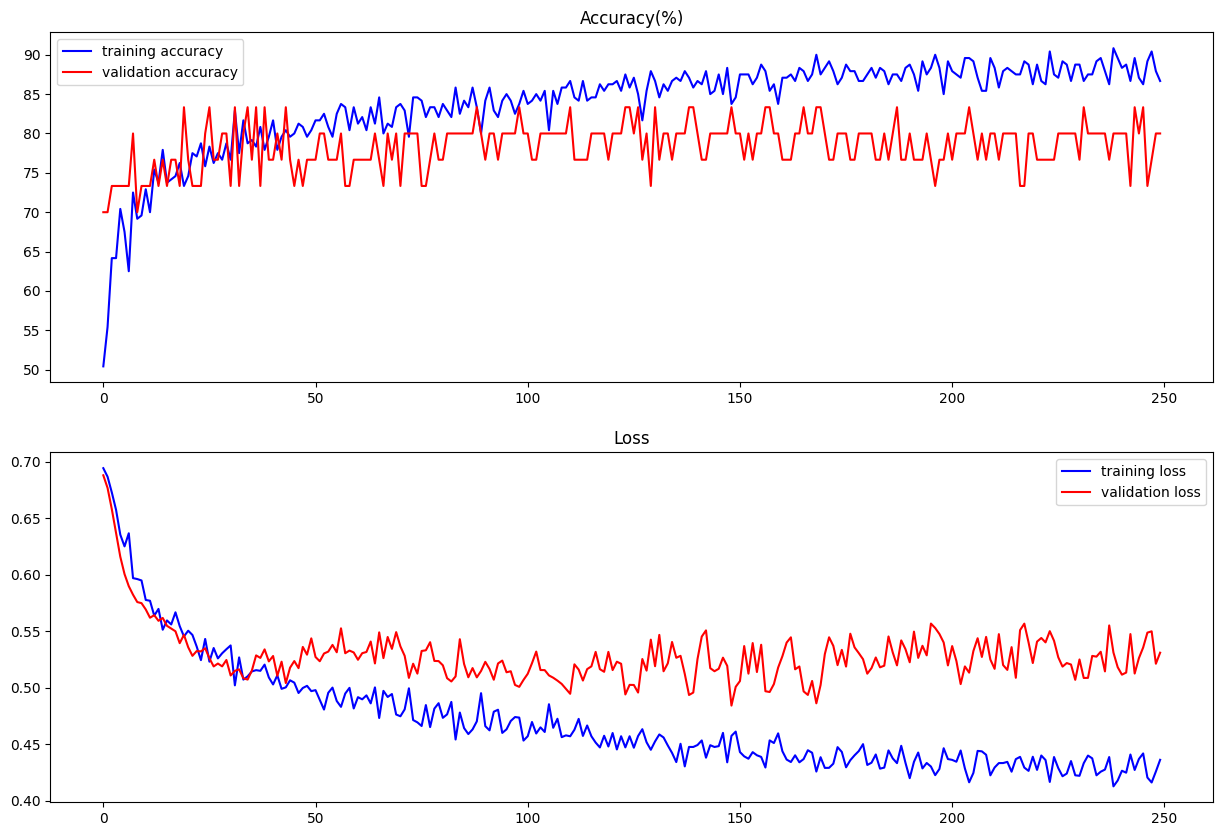

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(train_acc_his,'b',label='training accuracy')
plt.plot(valid_acc_his,'r',label='validation accuracy')
plt.title('Accuracy(%)')
plt.legend(loc='best')
plt.subplot(212)
plt.plot(train_losses_his,'b',label='training loss')
plt.plot(valid_losses_his,'r',label='validation loss')
plt.title('Loss')
plt.legend(loc='best')
plt.show()
#plt.savefig("training and validation fig.jpg")

## Prediction (After Training)

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images,labbels = images.to(device), labels.to(device)
        output = model(images).to(device)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# all_labels: ground truth labels
# all_preds: predicted labels

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision and recall for each class
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

# Print the results
print(f'Confusion matrix: {cm}\n')
print(f"Accuracy: {accuracy:.2f}\n")
print(f"Precision (per class): {precision}\n")
print(f"Recall (per class): {recall}\n")

Confusion matrix: [[11  3]
 [ 2 14]]

Accuracy: 0.83

Precision (per class): [0.84615385 0.82352941]

Recall (per class): [0.78571429 0.875     ]



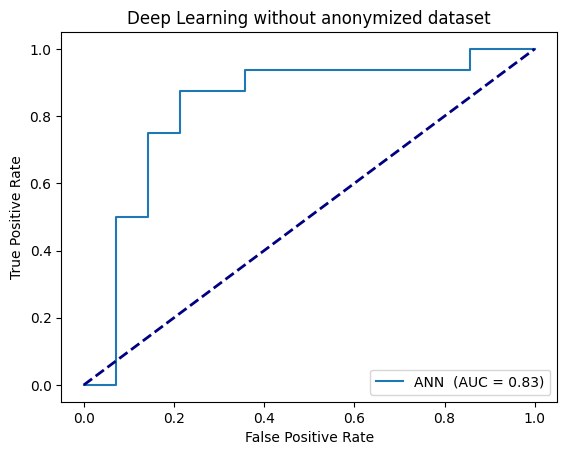

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
import numpy as np
import torch

all_probs = []
all_labels = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for inference
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images).to(device)  # Get model outputs
        #print(f'output: {output}')
        # Assuming output is a tensor of shape (batch_size, num_classes)
        #probs = torch.softmax(output, dim=1)  # Get predicted probabilities
        #print(f'probs: {probs}')
        
        # Collect all probabilities
        all_probs.extend(output.cpu().numpy())
        
        # Collect true labels
        all_labels.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='ANN ')

display.plot()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Deep Learning without anonymized dataset')
plt.legend(loc='lower right')
plt.show()
